In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from scipy.stats import gaussian_kde
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
url = "http://www.stat.columbia.edu/~gelman/arm/examples/child.iq/kidiq.dta"
df = pd.read_stata(url)
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
df.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
summary_stats = [np.mean, st.stdev]
df.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

In [6]:
89.319648 - 77.548387

11.771260999999996

In [7]:
# Vector of kid_score when mom_hs is 1
kid_score_mom_hs_1 = df[df["mom_hs"] == 1]["kid_score"]

# Vector of kid_score when mom_hs is 0
kid_score_mom_hs_0 = df[df["mom_hs"] == 0]["kid_score"]

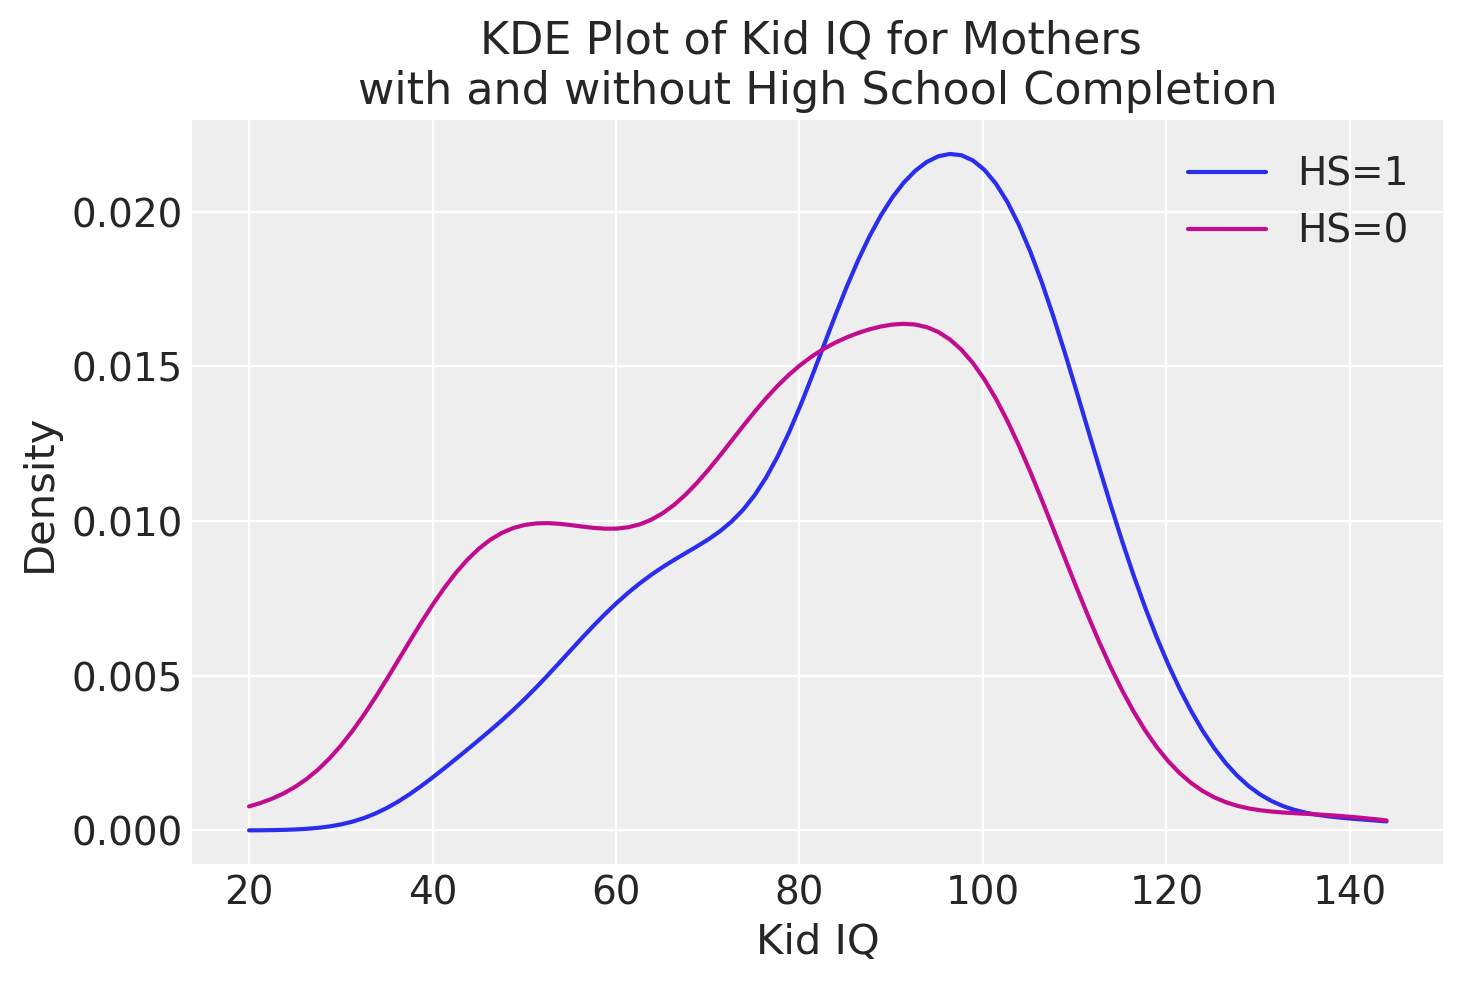

In [8]:
# Create a KDE for each group
kde_hs_1 = gaussian_kde(kid_score_mom_hs_1)
kde_hs_0 = gaussian_kde(kid_score_mom_hs_0)

# Generate x values for the plot
x_vals = np.linspace(
    min(np.min(kid_score_mom_hs_1), np.min(kid_score_mom_hs_0)),
    max(np.max(kid_score_mom_hs_1), np.max(kid_score_mom_hs_0)),
    100,
)

# Calculate KDE densities for the x values
density_hs_1 = kde_hs_1(x_vals)
density_hs_0 = kde_hs_0(x_vals)

# Create the plot
plt.title("KDE Plot of Kid IQ for Mothers \nwith and without High School Completion")
plt.xlabel("Kid IQ")
plt.ylabel("Density")

plt.plot(x_vals, density_hs_1, label="HS=1")
plt.plot(x_vals, density_hs_0, color="C3", label="HS=0")

# Show the legend
plt.legend();

In [9]:
with pm.Model() as model:
    # Prior per la deviazione standard dei gruppi
    group1_std = pm.HalfCauchy("group1_std", beta=30)
    group0_std = pm.HalfCauchy("group0_std", beta=30)

    # Prior per la media dei gruppi
    group1_mean = pm.Normal("group1_mean", mu=df.kid_score.mean(), sigma=20)
    group0_mean = pm.Normal("group0_mean", mu=df.kid_score.mean(), sigma=20)

    # Likelihood per i dati osservati nei gruppi
    mom_hs_1 = pm.Normal(
        "mom_hs_1", mu=group1_mean, sigma=group1_std, observed=kid_score_mom_hs_1
    )
    mom_hs_0 = pm.Normal(
        "mom_hs_0", mu=group0_mean, sigma=group0_std, observed=kid_score_mom_hs_0
    )

    # Calcolare la grandezza dell'effetto
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group0_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group0_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group0_std**2) / 2)
    )

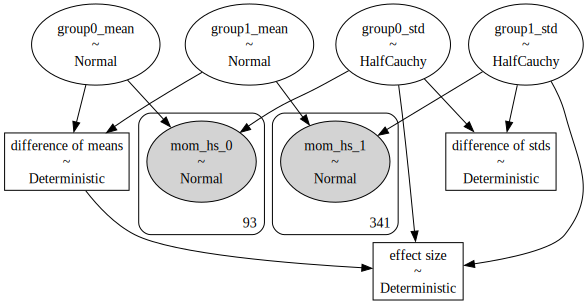

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    prior_samples = pm.sample_prior_predictive(30)

Sampling: [group0_mean, group0_std, group1_mean, group1_std, mom_hs_0, mom_hs_1]


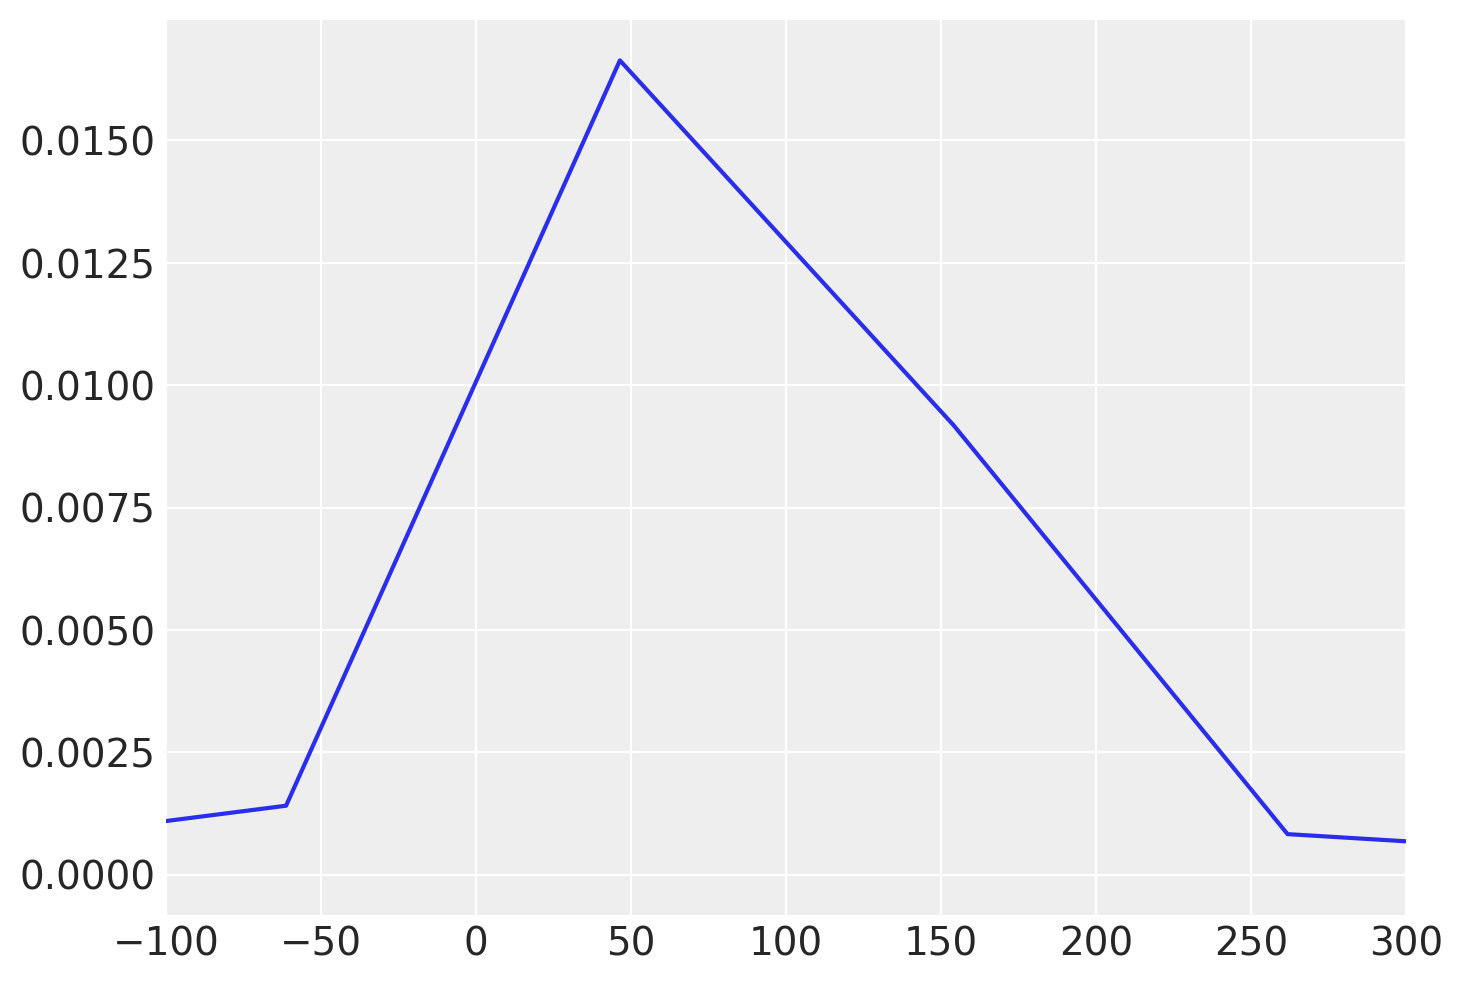

In [12]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_0"])
ax.set_xlim(-100, 300);

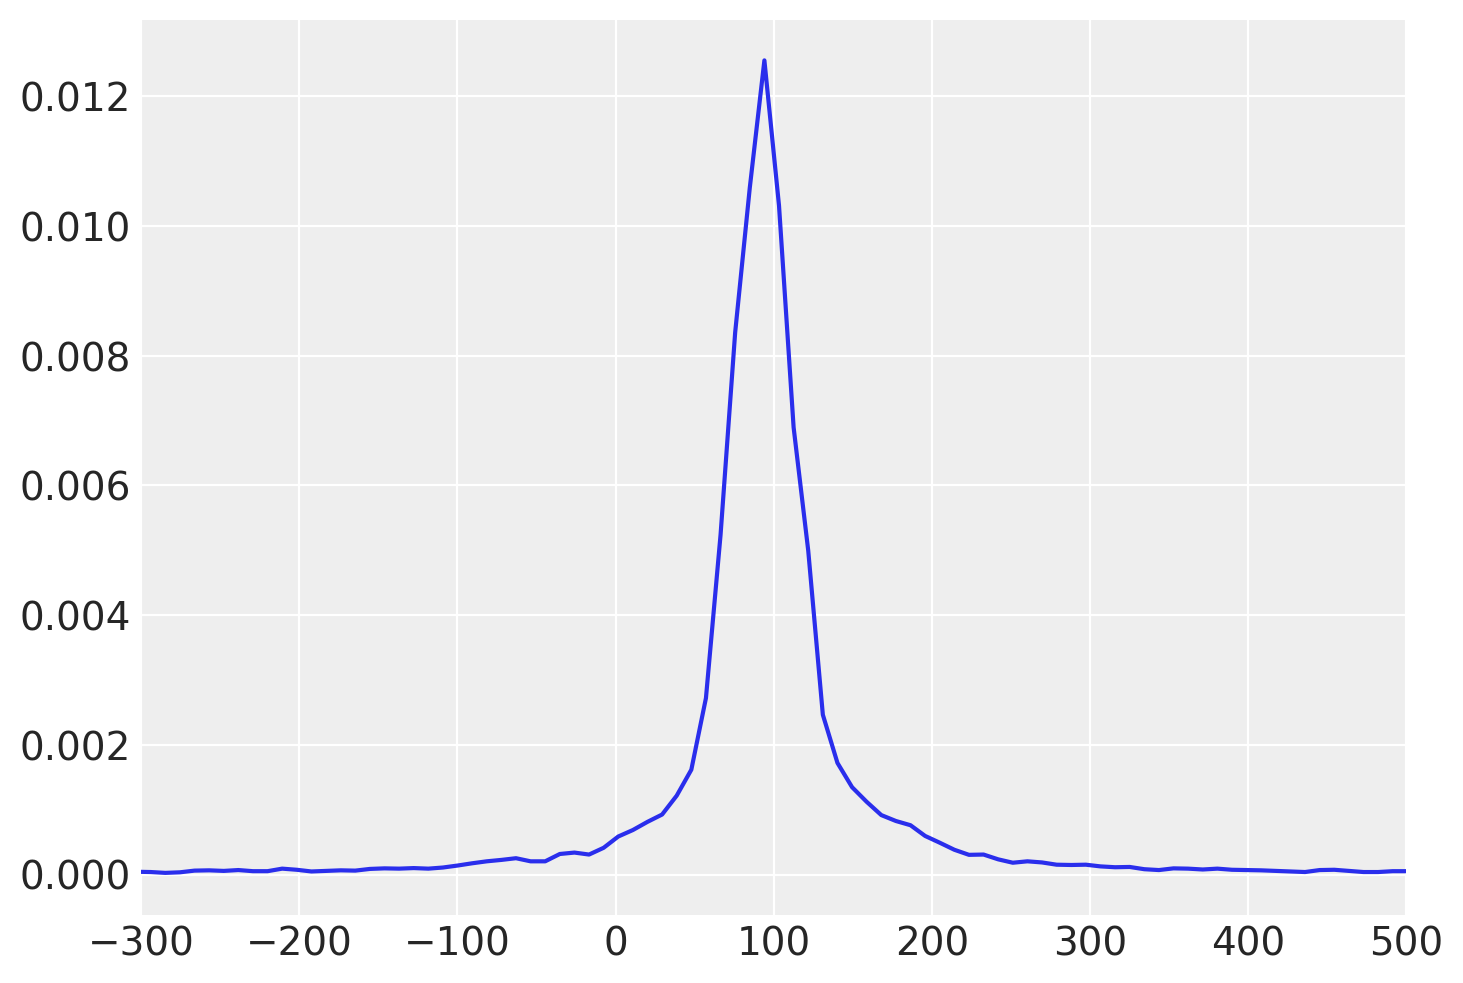

In [13]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_1"])
ax.set_xlim(-300, 500);

In [14]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


I0000 00:00:1699424776.139356       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Compilation time = 0:00:01.186758


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1187.23it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1188.02it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1188.93it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1189.64it/s]


Sampling time = 0:00:01.989527


Transforming variables...


Transformation time = 0:00:00.100693


/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_83124/1817941948.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


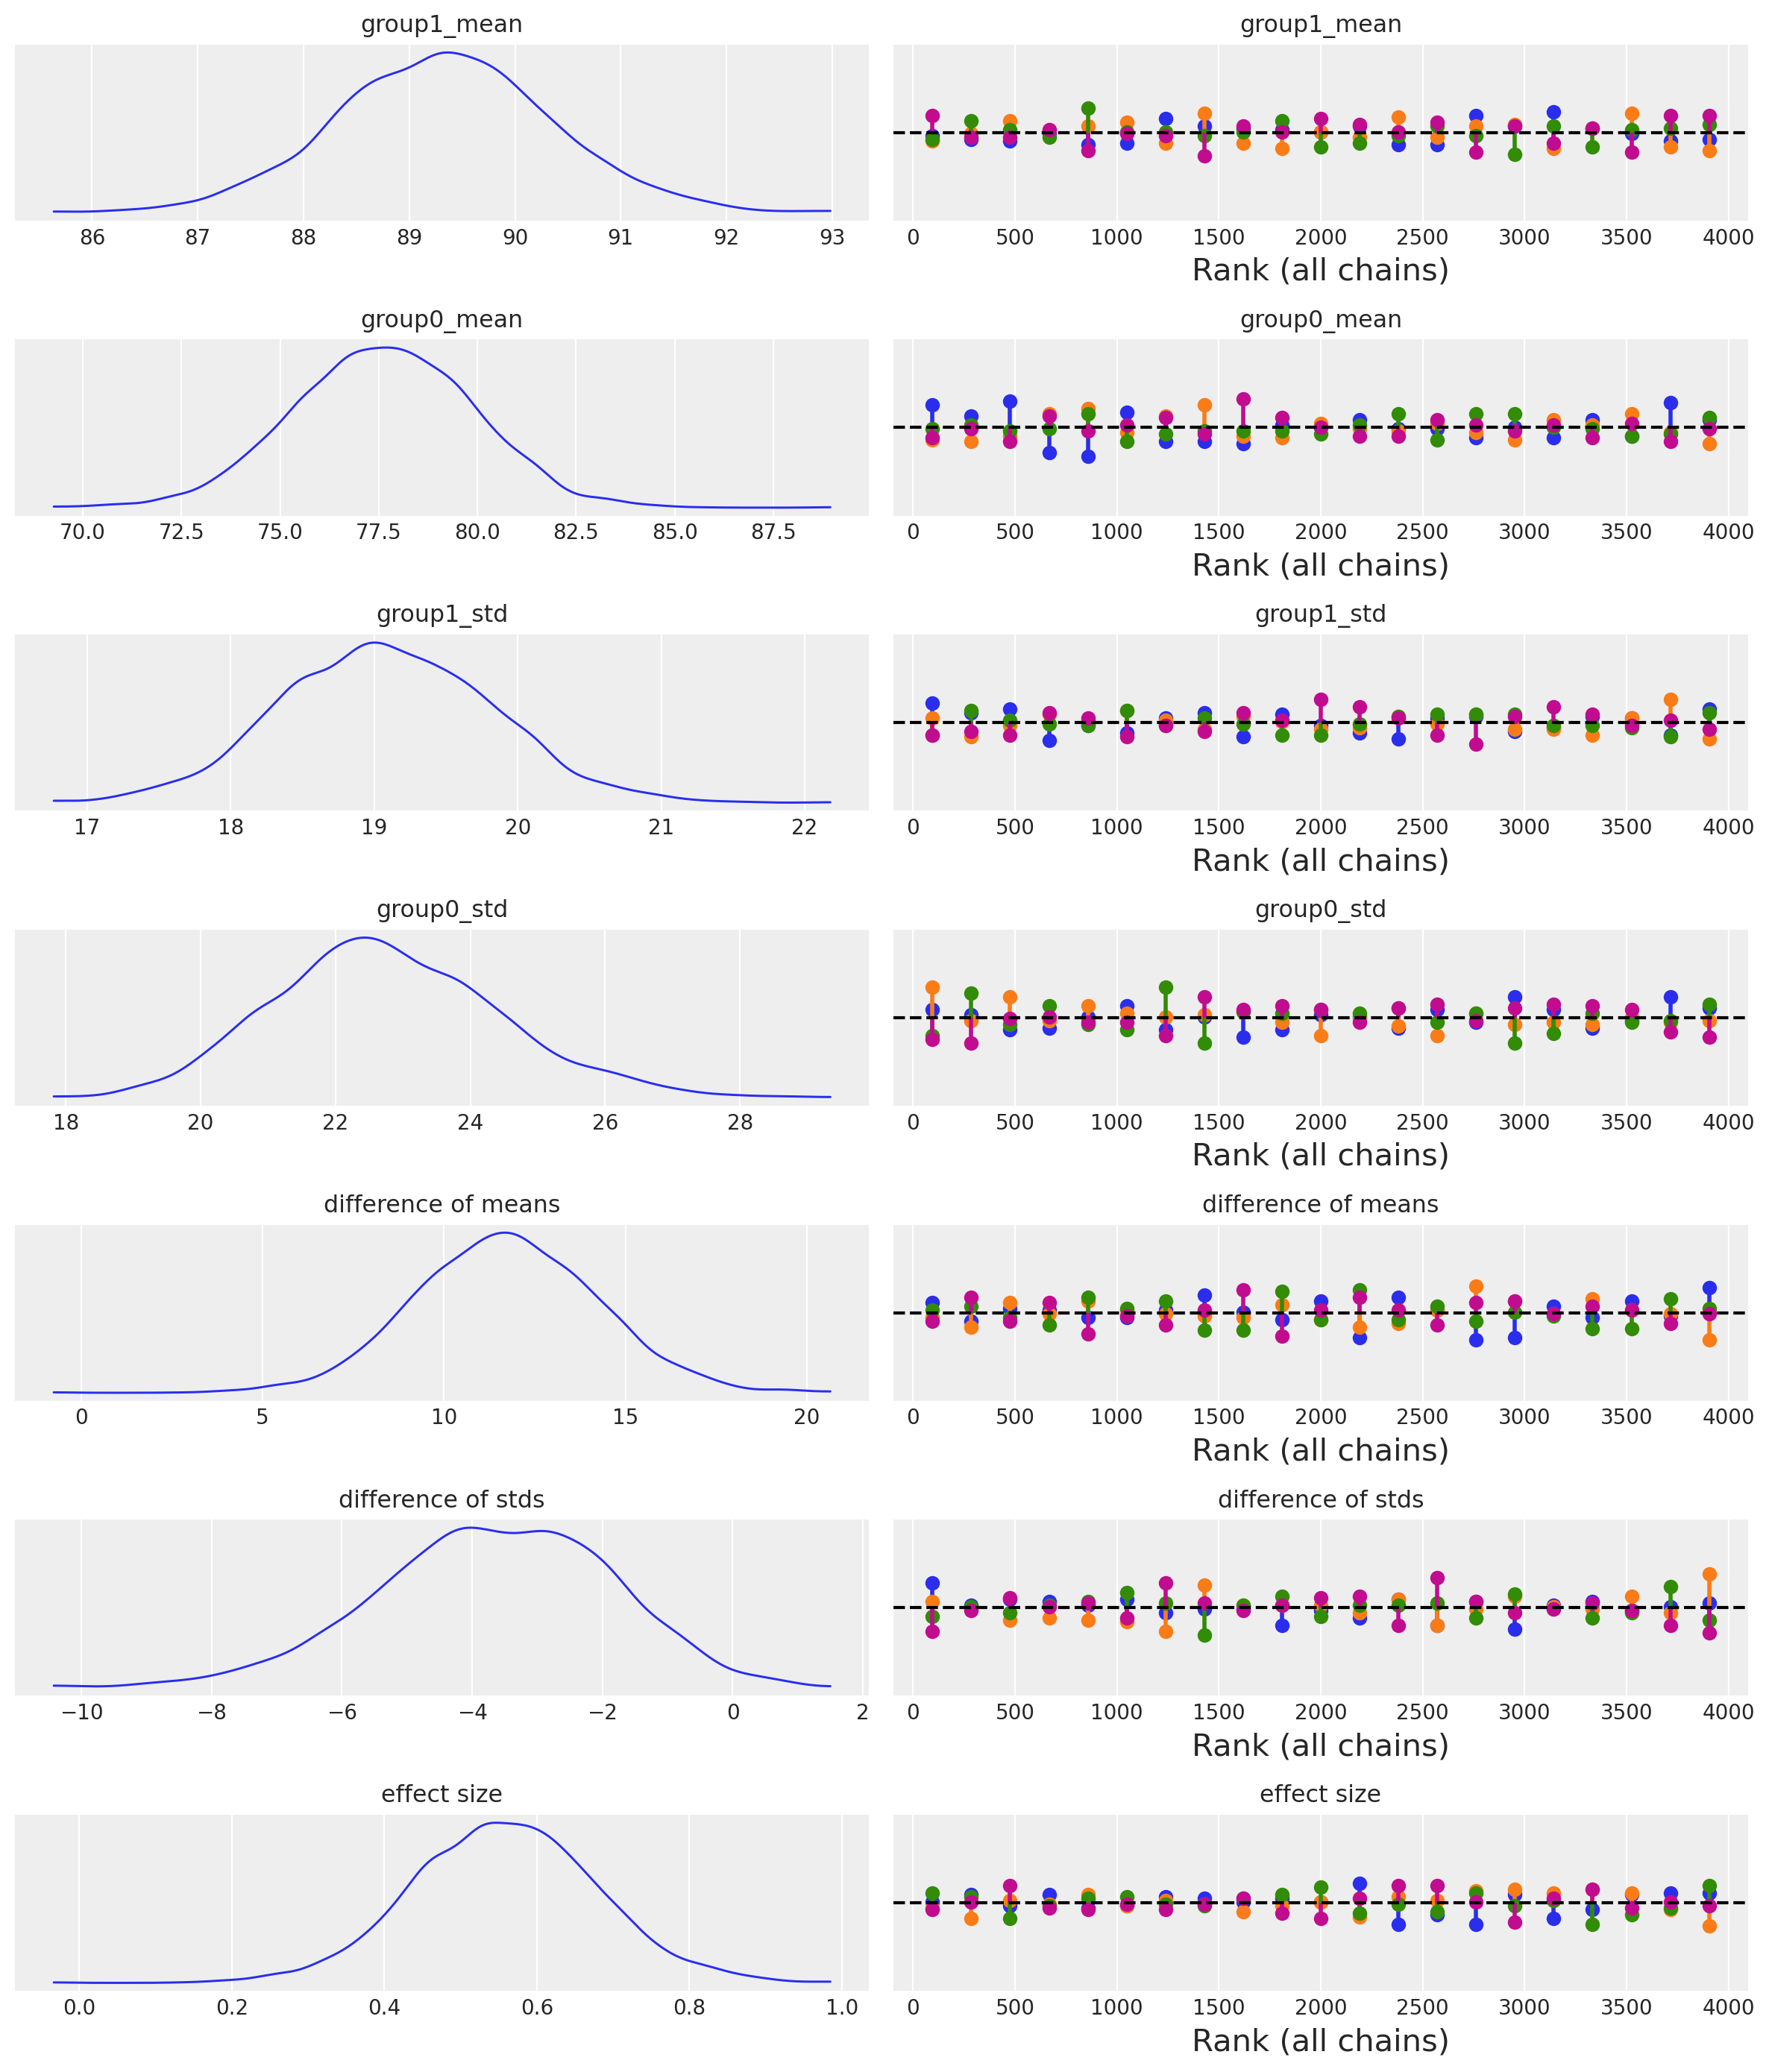

In [15]:
az.plot_trace(idata, combined=True, divergences="bottom", kind="rank_vlines")
plt.tight_layout();

In [16]:
az.summary(idata, var_names=["group1_mean", "group0_mean", "group1_std", "group0_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group1_mean,89.332,1.033,87.458,91.390,0.015,0.011,4559.0,3008.0,1.0
group0_mean,77.618,2.304,73.288,81.721,0.032,0.023,5134.0,2886.0,1.0
group1_std,19.087,0.735,17.727,20.495,0.011,0.008,4704.0,3131.0,1.0
group0_std,22.755,1.675,19.796,26.073,0.025,0.018,4577.0,3064.0,1.0


In [17]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,11.714,2.523,7.115,16.532,0.036,0.026,5068.0,2860.0,1.0
difference of stds,-3.668,1.810,-7.108,-0.402,0.027,0.020,4642.0,3042.0,1.0
effect size,0.558,0.122,0.323,0.782,0.002,0.001,5278.0,2932.0,1.0


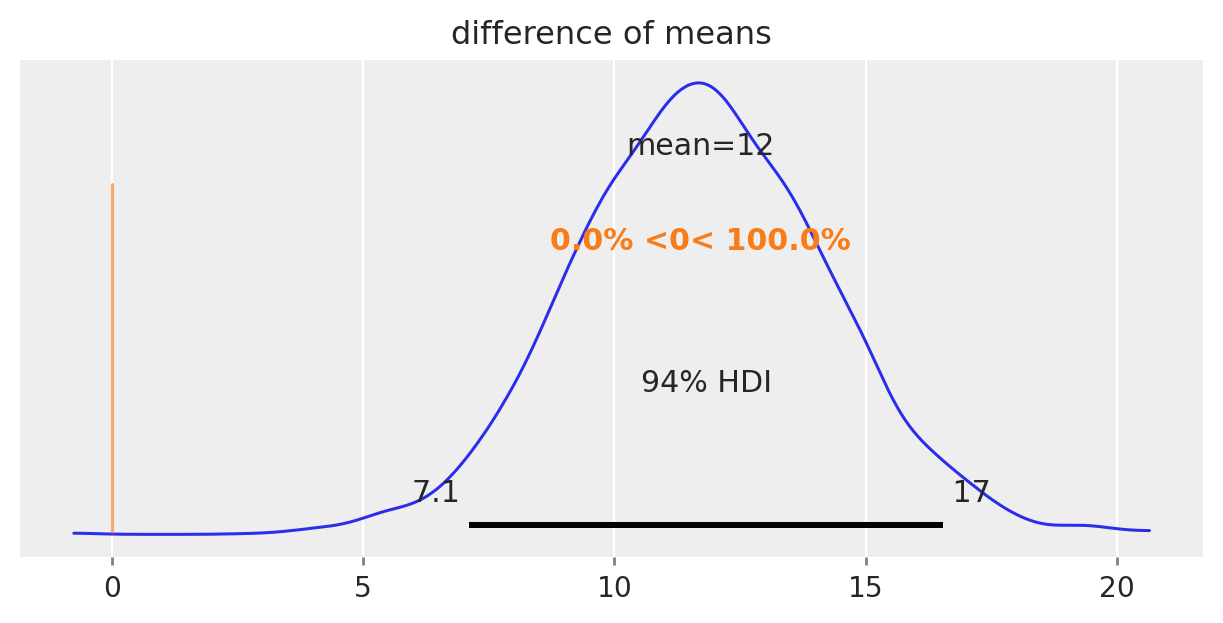

In [18]:
az.plot_posterior(idata, var_names="difference of means", ref_val=0, figsize=(6, 3));

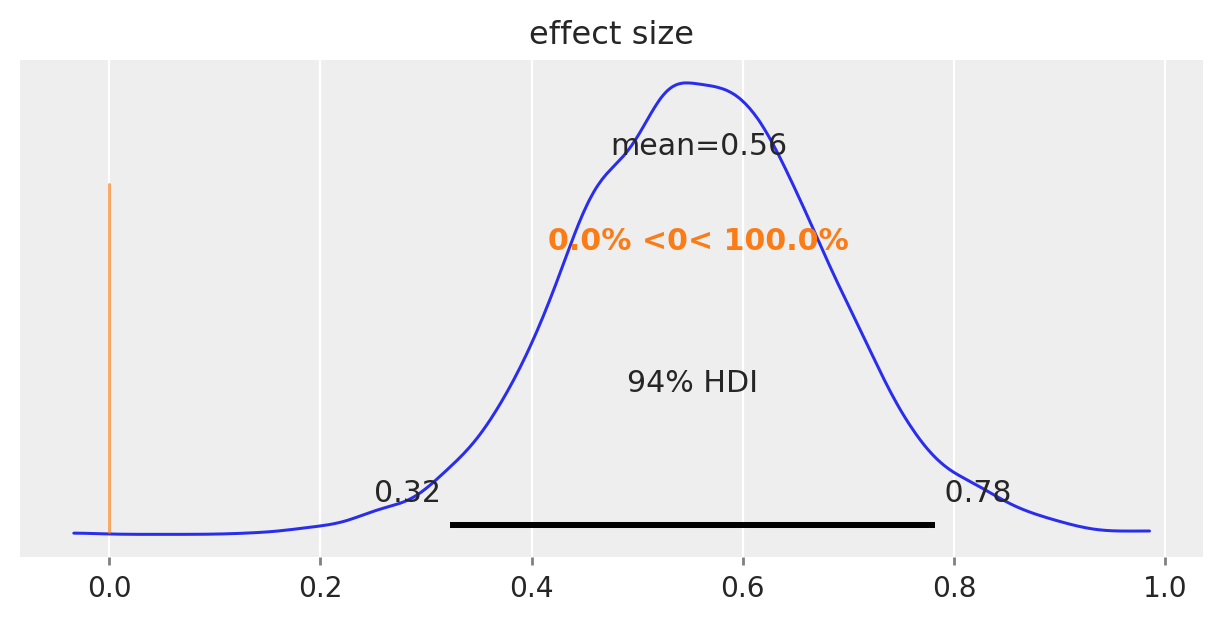

In [19]:
az.plot_posterior(idata, var_names="effect size", ref_val=0, figsize=(6, 3));

In [20]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [21]:
mu1_post = idata.posterior["group1_mean"]
mu0_post = idata.posterior["group0_mean"]

In [22]:
mu1_post.shape

(4, 1000)

In [23]:
print(np.mean(mu1_post < mu0_post))

<xarray.DataArray ()>
array(0.00025)


In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Nov 08 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

arviz     : 0.16.1
numpy     : 1.25.2
matplotlib: 3.8.0
pymc      : 5.9.1
seaborn   : 0.13.0
pandas    : 2.1.1

Watermark: 2.4.3

